In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import matplotlib.pyplot as plt
from typing import Callable
from functools import partial
import matplotlib
import pyext.src.poissonsqr as sqr

/opt/homebrew/lib/python3.10/site-packages/jax/_src/lib/__init__.py:34: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


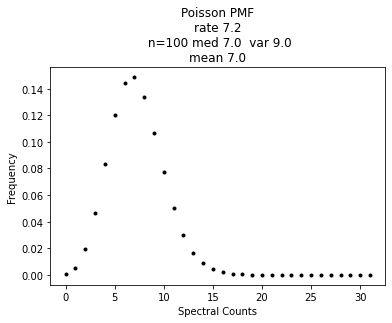

In [2]:
pmf = jsp.stats.poisson.pmf

x = np.arange(0, 32)
lamb = 7.2
y = pmf(x, lamb)

title = f"Poisson PMF\nrate {lamb}"
plt.plot(x, y, 'k.')
plt.xlabel('Spectral Counts')
plt.ylabel('Frequency')


# Generate random samples
key = jax.random.PRNGKey(113)
n = 100
samples = jax.random.poisson(key, lamb, [n])

med = np.median(samples)
med = np.round(med)
var = np.var(samples)
var = np.round(var)
mean = np.round(np.mean(samples))

title += f'\n n={n} med {med}  var {var}'
title += f'\nmean {mean}'
plt.title(title)
plt.show()

In [3]:
def slice_sweep__s(key, x: float, pstar: Callable, w: float) -> tuple:
    """Univariate Slice Sampling
    
    (x, u) -> (x', u')
    Maps a point x, u under the density function pstar to x' u'
    
    Folowing David MacKay Book

    Advantages:

    No need for tuning (opposed to Metropolis). src wikipedia
    Automatically adjusts the step size to match the local shape
    of the density function.
    Easier to implement than gibbs.
  
    Random variates exhibit seriel statistical dependance.
  
    For P(x) = 1/Z * P*(x)
    Thus P*(x) \propto P(x)
  
    MacKay Pseudocode
  
    1. evaluate P*(x)
    2. draw a vertical coordinate u' ~ Uniform(0, P*(x))
    3. create a horizontal interval (xl, xr) enclosing x
    4. loop {
    5.   draw x' ~ Uniform(xl, xr)
    6.   evaluate P*(x')
    7.   if P*(x') > u' break out of loop 4-9
    8.   else modify the interval (xl, xr)
    }
    
    Params:
    
      key: A jax.random.PRNGKeyArray
      x: A starting coordinate for the sweep within the domain of pstar
      pstar: A univariate (1-dimensional) probability mass or density function of one parameter.
             p(x)=1/Z*pstar(x). Thus pstar does not have to be normalized
      w: A weight parameter for the stepping our algorithm in step 3.
      
    Returns:
      x_prime, u_prim
    """
    
    k1, k2, k3, k4 = jax.random.split(key, 4)
    # step 1 evaluate pstar(x)
    u = pstar(x)
    
    # step 2 draw a vertical coordinate
    u_prime = jax.random.uniform(k1, minval=0, maxval=u)
    
    # step 3 create a horizontal interval (xl, xr) enclosing x
    r = jax.random.uniform(k2, minval=0, maxval=1)
    
    xl = x - r * w
    xr = x + (1 - r) * w
    
    xl = jax.lax.while_loop(lambda xl: pstar(xl) > u_prime, lambda xl: xl - w, xl)
    xr = jax.lax.while_loop(lambda xr: pstar(xr) > u_prime, lambda xr: xr + w, xr)
    
    # step 4 loop 1st iteration
    
    loop_break = False
    
    # step 5 draw x'
    x_prime = jax.random.uniform(k3, minval=xl, maxval=xr)
    
    # step 6 evaluate pstar(x')
    t = pstar(x_prime)
    
    
    def step7_true_func(val):
        """Do nothing break out of loop"""
        key, x, x_prime, xl, xr, u_prime, t, loop_break = val
        loop_break = True
        return key, x, x_prime, xl, xr, u_prime, t, loop_break

    def step8(val):
        """Perform the shrinking method for step 8"""
        key, x, x_prime, xl, xr, u_prime, t, loop_break = val       
        
        x_prime, x, xr, xl = jax.lax.cond(
            x_prime > x, 
            lambda x_prime, x, xr, xl: (x_prime, x, x_prime, xl),  # reduce the right side
            lambda x_prime, x, xr, xl: (x_prime, x, xr, x_prime),  # reduce the left side
            *(x_prime, x, xr, xl))
        
        return key, x, x_prime, xl, xr, u_prime, t, loop_break
    
    def step7_and_8(val):
        val = jax.lax.cond(
            val[6] > val[5], # p*(x')>u'
            step7_true_func, # do nothing. Break out of loop
            step8, # step 8 modify the interval (xl, xr)
            val)
        
        return val

    # step 7 if pstar(x') > u' break out of loop. else modify interval
    
    val = k4, x, x_prime, xl, xr, u_prime, t, loop_break
    val = step7_and_8(val)

    def step4_loop_body(val):
        
        # step 5 draw x'
        key, x, x_prime, xl, xr, u_prime, t, loop_break = val 
        key, subkey = jax.random.split(key)
        x_prime = jax.random.uniform(subkey, minval=xl, maxval=xr)
        
        # step 6 evaluate pstar(x')
        t = pstar(x_prime)
        
        # step 7
        
        val = key, x, x_prime, xl, xr, u_prime, t, loop_break
        val = step7_and_8(val)
        return val
    
    # End 1st loop iteration
    # Continue the loop executing the while loop
    
    def while_cond_func(val):
        """Check the loop break condition,
           terminate the loop if True"""
        key, x, x_prime, xl, xr, u_prime, t, loop_break = val
        return loop_break == False
    
    val = jax.lax.while_loop(
        while_cond_func, # check the loop break condition
        step4_loop_body, 
        val) # u_prime <= p*(x') i.e., t
        
    return val

In [4]:
w = 50
rate = 11
key = jax.random.PRNGKey(13)



fa = partial(jsp.stats.norm.pdf, loc=10, scale=2)
fb = partial(jsp.stats.poisson.pmf, mu=100)

def pstar(x):
    return fa(x) + fb(x)
x=7

#pstar = partial(jsp.stats.norm.pdf, loc=rate, scale=9)
pstar = partial(jsp.stats.poisson.pmf, mu=rate)

slice_sweep = partial(slice_sweep__s,
                     pstar=pstar,
                     w=w,
                     )

ss = jax.jit(slice_sweep)

def sample(key, nsamples, ss, x):
    samples = jnp.zeros(nsamples)
    for i in range(nsamples):
        key, subkey = jax.random.split(key)
        val = ss(key=subkey, x=x)
        key, x, x_prime, xl, xr, u_prime, t, loop_break = val
        x = x_prime
        samples = samples.at[i].set(x_prime)
    
    return samples



key = jax.random.PRNGKey(13)
x = 3


ss(key=key, x=x)

(DeviceArray([2853110258, 2671382889], dtype=uint32),
 DeviceArray(3, dtype=int32, weak_type=True),
 DeviceArray(19.17338, dtype=float32),
 DeviceArray(-5.537883, dtype=float32),
 DeviceArray(44.462116, dtype=float32),
 DeviceArray(0.00323145, dtype=float32),
 DeviceArray(0.00759756, dtype=float32),
 DeviceArray(True, dtype=bool, weak_type=True))

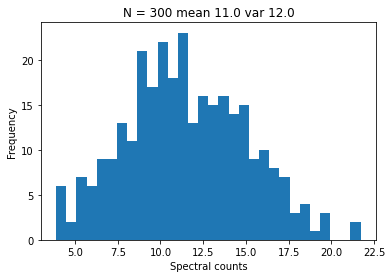

In [5]:
# sample using the poisson pmf

nsamples = 300
samples = sample(key, nsamples, ss, x)

samples = np.array(samples)
plt.hist(samples, bins=30)
plt.xlabel('Spectral counts')
plt.ylabel('Frequency')
plt.title(f'N = {nsamples} mean {np.round(np.mean(samples))} var {np.round(np.var(samples))}')
plt.show()

In [6]:
# ulog = eta1 * xi + eta2 * sqrt(xi) -log(xi!)
d = 2
theta = jnp.array([-11., -5])

off_diag = 0.
phi = jnp.array([[1, off_diag],
                  [off_diag, 1]])

xarr = jnp.array([30., 3.])
w=50

ulog_target__j = sqr.get_ulog_score__s(theta, phi, xarr)

f_node0 = partial(ulog_target__j, i=0, theta=theta, phi=phi)
f_node1 = partial(ulog_target__j, i=1, theta=theta, phi=phi)


def pstar(x, i, theta, phi,  xarr=jnp.ones(2)):
    xarr = xarr.at[i].set(x)
    return ulog_target__j(theta, phi, xarr, i)


def gibbs__step__s(key, theta, phi, xarr, w):
    
    # Make PRNGKeys
    
    k0, k1 = jax.random.split(key)
    
    # Generate from node conditional 0
    
    pstar0 = partial(pstar, i=0, theta=theta, phi=phi, xarr=xarr)
    val = slice_sweep__s(key=k0, x=xarr[0], pstar=pstar0, w=w)
    old_key0, x0, x0_prime, xl, xr, u_prime, t, loop_break = val
    
    # Update the joint independant variable
    xarr = xarr.at[0].set(x0_prime)
    
    # Generate from node conditional 1
    pstar1 = partial(pstar, i=1, theta=theta, phi=phi, xarr=xarr)
    val = slice_sweep__s(key=k2, x=xarr[1], pstar=pstar1, w=w)
    
    
    val = slice_sweep__s(key=k1, x=x)
    old_key1, x1, x1_prime, xl, xr, u_prime, t, loop_break = val
    
    return (x0_prime, x1_prime)
    


Text(0.5, 0, 'spectral counts')

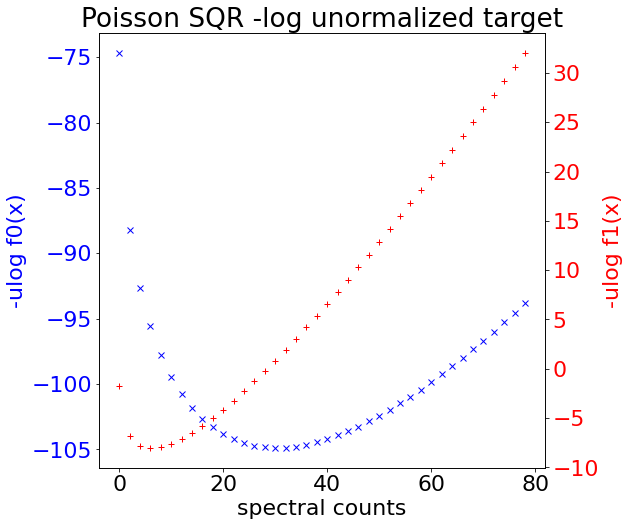

In [7]:

pstar0 = partial(pstar, theta=theta, phi=phi, xarr=xarr, i=0)
x = np.arange(0, 80, 2)
y = np.array(list(map(pstar0, x)))


font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}
y0 = y
matplotlib.rc('font', **font)

figsize = (8, 8)

fig, ax = plt.subplots(figsize = (8, 8))
ax1 = ax.twinx()

c1 = 'b'

ax.set_ylabel('-ulog f0(x)', color=c1)
ax.tick_params(axis='y', labelcolor=c1)
ax.plot(x, y, f'{c1}x')

pstar1 = partial(pstar, theta=theta, phi=phi, xarr=xarr, i=1)
y = np.array(list(map(pstar1, x)))

c2 = 'r'
ax1.set_ylabel('-ulog f1(x)', color=c2)
ax1.tick_params(axis='y', labelcolor=c2)
ax1.plot(x, y, f'{c2}+')

plt.title(f"Poisson SQR -log unormalized target")
ax.set_xlabel('spectral counts')
#ax1.plot(x, np.exp(y), 'b+')

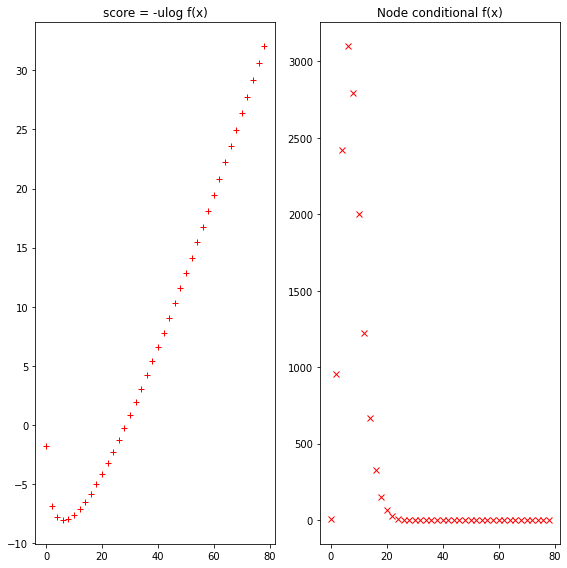

In [8]:
%matplotlib inline
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}

plt.figure(figsize=(8,8))


plt.subplot(121)
plt.title('score = -ulog f(x)')
plt.plot(x, y, 'r+')
plt.subplot(122)
f = np.exp(-y)
plt.plot(x, f, 'rx')
plt.title(f'Node conditional f(x)')
plt.tight_layout()

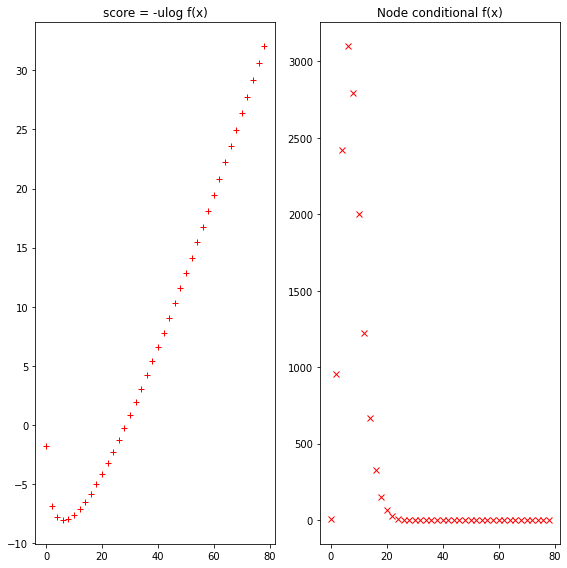

In [9]:
%matplotlib inline
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}

plt.figure(figsize=(8,8))


plt.subplot(121)
plt.title('score = -ulog f(x)')
plt.plot(x, y, 'r+')
plt.subplot(122)
f = np.exp(-y)
plt.plot(x, f, 'rx')
plt.title(f'Node conditional f(x)')
plt.tight_layout()

In [10]:
def npstar0(x):
    return -pstar0(x)

def npstar1(x):
    return -pstar1(x)

w=50
rseed = 13
key = jax.random.PRNGKey(rseed)

ss1 = partial(slice_sweep, pstar=npstar0, w=w)
ss2 = partial(slice_sweep, pstar=npstar1, w=w)

jax.jit(ss1)(key, xarr[0])
jax.jit(ss2)(key, xarr[1])


def gibbs_step(key, xarr):
    
    k1, k2 = jax.random.split(key)
    
    # Sample node conditional 0
    #val = slice_sweep(k1, x=xarr[0], pstar=npstar0, w=w)
    
    val = ss1(k1, x=xarr[0])
    old_key0, x0, x0_prime, xl, xr, u_prime, t, loop_break = val
    
    # Update slice
    xarr = xarr.at[0].set(x0_prime)
    # Sample Node conditional 1
    
    #val = slice_sweep(k2, x=xarr[1], pstar=npstar1, w=w)
    val = ss2(k2, x=xarr[1])
    old_key1, x1, x1_prime, xl, xr, u_prime, t, loop_break = val
    xarr = xarr.at[1].set(x1_prime)
    
    return xarr


def gibbs_sampler(key, n_steps, x_init):
        
    """
    for step in range(n_steps):
        print(f'Sampling step {step}')
        x_init = gibbs_step(keys[step], x_init)
        samples = samples.at[step].set(x_init)
    """
    
    keys = jax.random.split(key, n_steps)
    samples = jnp.zeros((n_steps, 2))

    def gibbs_body_fun(i, val):
        keys, x_init, samples = val
        x_init = gibbs_step(keys[i], x_init)
        samples = samples.at[i].set(x_init)
        val = keys, x_init, samples
        return val
    
    val = keys, x_init, samples
    val = jax.lax.fori_loop(0, n_steps, gibbs_body_fun, val)
    keys, x_init, samples = val

    
    return samples

#samples = gibbs_sampler(key, 100, jnp.array([11., 90.]))

n_steps = 1000000
x_init = jnp.array([2., 1.])

#jit compile the sampler
gibbs_sampler = partial(gibbs_sampler, n_steps=n_steps)
gibbs_sampler = jax.jit(gibbs_sampler)


chain1 = gibbs_sampler(key=key, x_init = x_init)
key2 = jax.random.PRNGKey(44)
x_init = jnp.array([97., 43.])
chain2 = gibbs_sampler(key=key2, x_init = x_init)
key3 = jax.random.PRNGKey(1948)
x_init = jnp.array([1., 32.])
chain3 = gibbs_sampler(key=key3, x_init = x_init)

samples = jnp.zeros((3 * n_steps, 2))
samples = samples.at[0:n_steps, :].set(chain1)
samples = samples.at[n_steps:2*n_steps, :].set(chain2)
samples = samples.at[2*n_steps:, :].set(chain3)

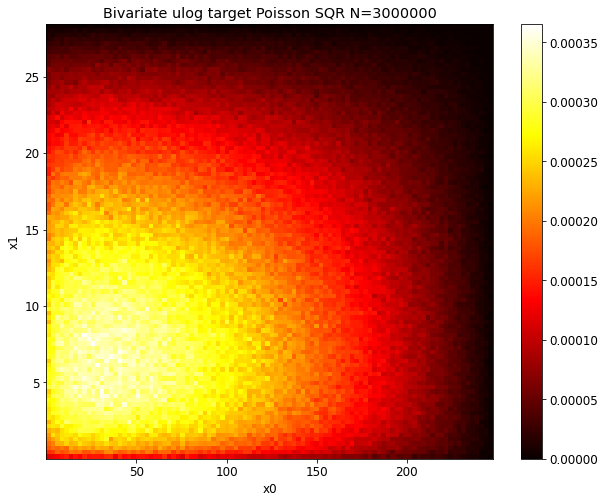

In [11]:
%matplotlib inline
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

nbins=100
samples = np.array(samples)
plt.figure(figsize=(10, 8))
hist2dr = plt.hist2d(samples[:,0], samples[:, 1], bins=nbins, cmap='hot', density=True)
plt.xlabel('x0')
plt.ylabel('x1')
plt.title(f'Bivariate ulog target Poisson SQR N={len(samples)}')
plt.colorbar()
plt.show()
h = hist2dr[0]

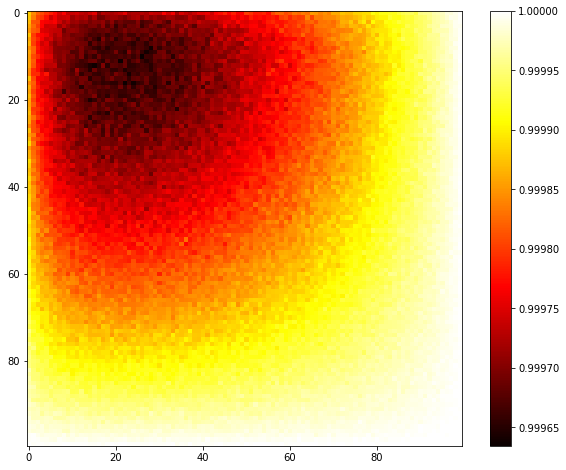

In [12]:
%matplotlib inline
plt.figure(figsize=(10, 8))
plt.imshow(np.exp(-h), cmap='hot')
plt.colorbar()


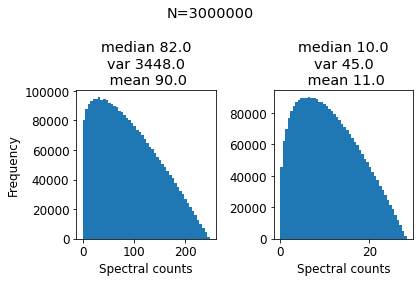

In [13]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

def poisson_pair_plot(samples):
    med = np.round(np.median(samples[:, 0]))
    med1 = np.round(np.median(samples[:, 1]))
    var = np.round(np.var(samples[:, 0]))
    var1 = np.round(np.var(samples[:, 1]))
    
    mean = np.round(np.mean(samples[:, 0]))
    mean1 = np.round(np.mean(samples[:, 1]))

    nbins = 50
    plt.suptitle(f'N={len(samples)}')
    plt.subplot(121)
    plt.title(f'median {med}\nvar {var}\n mean {mean}' )
    plt.hist(samples[:,0], bins=nbins)
    plt.xlabel('Spectral counts')
    plt.ylabel('Frequency')
    plt.subplot(122)
    plt.title(f'median {med1}\nvar {var1}\n mean {mean1}' )
    plt.hist(samples[:,1], bins=nbins)
    plt.tight_layout()
    plt.xlabel('Spectral counts')
    plt.show()
    
poisson_pair_plot(samples)

Text(0.5, 1.0, 'med 0.0, var 0.0')

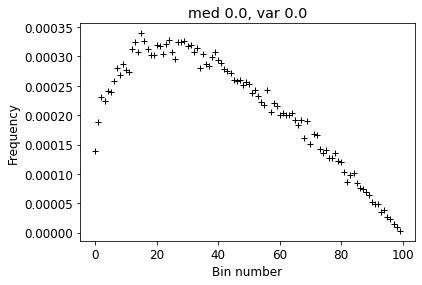

In [14]:
# Node Conditional Distributions
h = hist2dr[0]
x_bin_number = 25
plt.plot(h[x_bin_number,: ], 'k+')
plt.xlabel('Bin number')
plt.ylabel('Frequency')
med = np.round(np.median(h[:, 10]))
var = np.round(np.var(h[:, 10]))
plt.title(f'med {med}, var {var}')

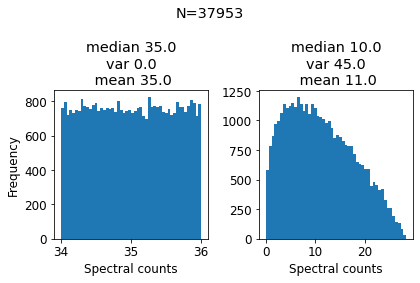

In [15]:
x0_50 = samples[samples[:, 0] <= 36]
x0_50 = x0_50[x0_50[:, 0] > 34]

poisson_pair_plot(x0_50)

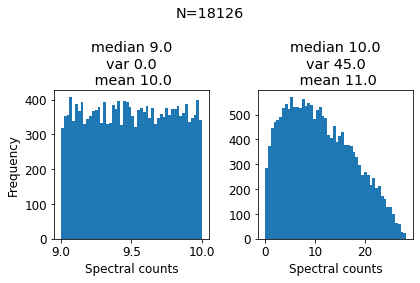

In [16]:
x0_50 = samples[samples[:, 0] <= 10]
x0_50 = x0_50[x0_50[:, 0] > 9]

poisson_pair_plot(x0_50)

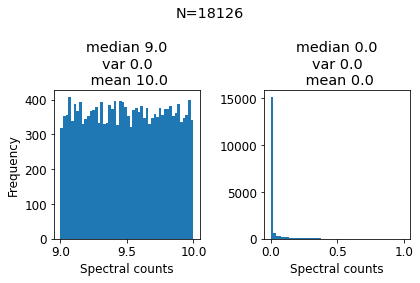

In [17]:
samples_f = samples.copy()
samples_f[:, 0] = 0.
samples_f = np.exp(-samples_f)
samples_f[:, 0] = samples[:, 0]

x0_50 = samples_f[samples_f[:, 0] <= 10]
x0_50 = x0_50[x0_50[:, 0] > 9]

poisson_pair_plot(x0_50)

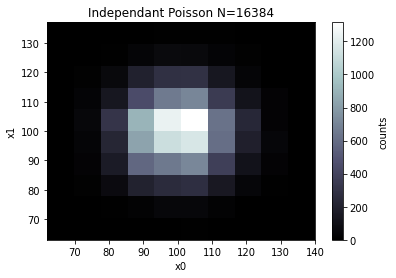

In [273]:
# Decoy Networks: Case 1 Bivariate independant poisson

nsamples = 2048*2*2*2
lam = 100
nbins = 10
cmap = 'bone'
key = jax.random.PRNGKey(13)
samples = jax.random.poisson(key, lam, shape=[nsamples, 2])
x0, x1 = samples[:, 0], samples[:, 1]
x0 = np.array(x0)
x1 = np.array(x1)
%matplotlib inline


plt.hist2d(x0, x1, cmap=cmap, bins=nbins)
plt.colorbar(label='counts')
plt.title(f'Independant Poisson N={nsamples}')
plt.xlabel('x0')
plt.ylabel('x1')
plt.show()

In [ ]:
scores = []

scalars = np.arange(-scaler, scaler)

In [259]:
# Case one

scaler = 5.
theta = jnp.array([scaler, scaler])

phi0 = jnp.array([[scaler/2, 0.],
                  [0., scaler/2]])

phi1 = jnp.array([[scaler/2, -scaler],
                  [-scaler, scaler/2]])

phi2 = jnp.array([[scaler/2, scaler],
                  [scaler, scaler/2]])



In [274]:

# (2, 2, nsamples)


def get_score_array(samples):
    score_array = jnp.zeros((3, 2, len(samples)))


    def body(i, val):

        samples, sa = val
        pair = samples[i]

        sa = sa.at[0, 0, i].set(ulog_target__j(x=pair, theta=theta, phi=phi0, i=0))
        sa = sa.at[0, 1, i].set(ulog_target__j(x=pair, theta=theta, phi=phi0, i=1))


        sa = sa.at[1, 0, i].set(ulog_target__j(x=pair, theta=theta, phi=phi1, i=0))
        sa = sa.at[1, 1, i].set(ulog_target__j(x=pair, theta=theta, phi=phi1, i=1))

        sa = sa.at[2, 0, i].set(ulog_target__j(x=pair, theta=theta, phi=phi2, i=0))
        sa = sa.at[2, 1, i].set(ulog_target__j(x=pair, theta=theta, phi=phi2, i=1))

        val = samples, sa
        return val

    #val = samples, phi0_i0, phi0_i1, phi1_i0, phi1_i1, phi2_i0, phi2_i1
    val = samples, score_array
    val = jax.lax.fori_loop(0, len(samples), body, val)
    #samples, phi0_i0, phi0_i1, phi1_i0, phi1_i1, phi2_i0, phi2_i1 = val
    samples, sa = val

    sa = np.array(sa)
    return sa



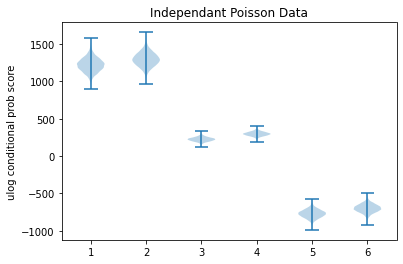

In [275]:
def plot_score_array(sa, title=''):
    
    # Negative, positive, zero
    plt.violinplot([sa[2, 0, :], sa[2, 1, :], sa[0, 0, :], sa[0, 1, :], sa[1, 0, :], sa[1, 1, :]])

    plt.title(title)
    plt.ylabel('ulog conditional prob score')
    plt.show()

sa = get_score_array(samples)
plot_score_array(sa, title='Independant Poisson Data')

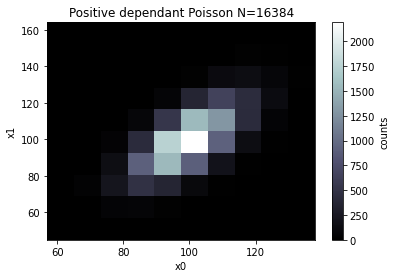

In [276]:
# Case 2 Positive dependance (correlation)

key = jax.random.PRNGKey(13)
k0, k1 = jax.random.split(key)
x0 = jax.random.poisson(key, lam, shape=[nsamples])
x1 = jax.random.poisson(k1, x0, shape=[nsamples])
x0 = np.array(x0)
x1 = np.array(x1)

%matplotlib inline

plt.hist2d(x0, x1, cmap=cmap, bins=nbins)
plt.colorbar(label='counts')
plt.title(f'Positive dependant Poisson N={nsamples}')
plt.xlabel('x0')
plt.ylabel('x1')
plt.show()

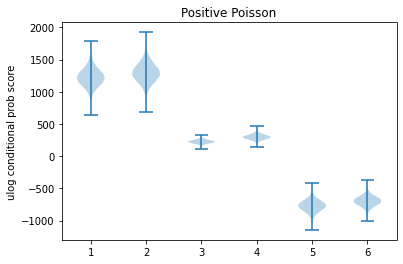

In [277]:
samples = jnp.array([x0, x1]).T
sa2 = get_score_array(samples)
plot_score_array(sa2, title='Positive Poisson')

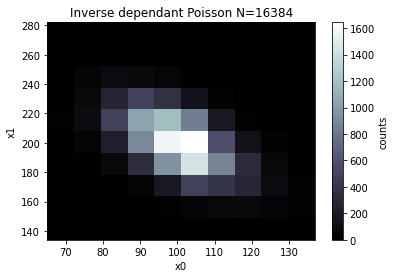

In [278]:
# Case 3 Negative dependance

key = jax.random.PRNGKey(13)
k0, k1 = jax.random.split(key)

x0 = jax.random.poisson(k0, lam, shape=[nsamples])


x1 = jax.random.poisson(k1, 300 - x0, shape=[nsamples])

antiplt = plt.hist2d(x0, x1, cmap=cmap, bins=nbins)
gs = gridspec.GridSpec(2, 2, width_ratios=[1,3], height_ratios=[3,1])


plt.colorbar(label='counts')
plt.title(f'Inverse dependant Poisson N={nsamples}')
plt.xlabel('x0')
plt.ylabel('x1')
plt.show()

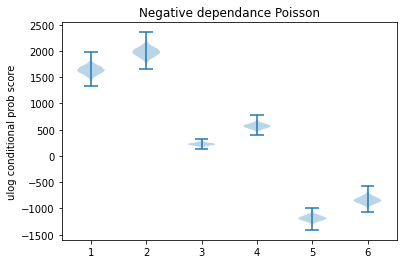

In [279]:
samples = jnp.array([x0, x1]).T
sa3 = get_score_array(samples)
plot_score_array(sa3, title='Negative dependance Poisson')

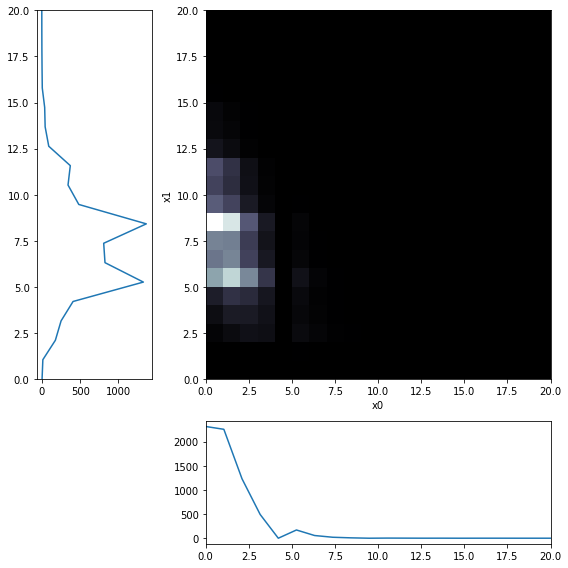

In [160]:
from matplotlib import gridspec


def dens_plot(a):
    t = np.linspace(0, len(a), len(a))
    f = np.linspace(0, len(a), len(a))
    a = np.exp(-np.abs(f-200)/200)[:, None] * np.random.rand(t.size)
    flim = (f.min(), f.max())
    tlim = (t.min(), t.max())

    fig = plt.figure(figsize=(8, 8))
    gs = gridspec.GridSpec(2, 2, width_ratios=[1,3], height_ratios=[3,1])
    ax = plt.subplot(gs[0,1])
    axl = plt.subplot(gs[0,0], sharey=ax)
    axb = plt.subplot(gs[1,1], sharex=ax)

    ax.set_xlabel('x0')
    ax.set_ylabel('x1')

    a = antiplt[0]
    ax.imshow(a, origin='lower', extent=tlim+flim, aspect='auto', cmap='bone')
    plt.xlim(tlim)

    axl.plot(a.mean(1), f)
    axb.plot(t, a.mean(0))
    plt.tight_layout()
    
dens_plot(antiplt[0])

In [125]:
?np.linspace

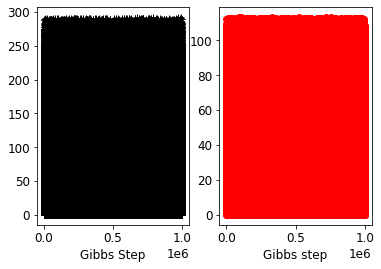

In [139]:


med = np.round(np.median(samples[:, 0]))
med1 = np.round(np.median(samples[:, 1]))

plt.subplots()
plt.subplot(121)
plt.xlabel('Gibbs Step')
plt.plot(samples[:, 0], 'k+')
plt.subplot(122)
plt.plot(samples[:, 1], 'ro')
plt.xlabel('Gibbs step')
plt.show()

In [26]:
samples

array([[158.15778 ,  63.81978 ],
       [187.01912 ,  69.80489 ],
       [222.15436 ,  26.962427],
       ...,
       [ 48.231247,  32.234093],
       [ 24.69851 ,  42.273773],
       [ 61.578182,  46.334133]], dtype=float32)

In [143]:
x0_50

array([[49.588108, 25.942923],
       [49.711395, 16.570082],
       [49.55668 ,  6.763094],
       ...,
       [49.242935, 46.65686 ],
       [49.41319 , 65.76452 ],
       [49.248604, 41.628567]], dtype=float32)

In [116]:
samples.shape

(100000, 2)

In [71]:
s = s.at[3].set([2., 2.])

In [72]:
s

DeviceArray([[0., 0.],
             [0., 0.],
             [0., 0.],
             [2., 2.],
             [0., 0.],
             [0., 0.],
             [0., 0.],
             [0., 0.],
             [0., 0.],
             [0., 0.],
             [0., 0.],
             [0., 0.],
             [0., 0.],
             [0., 0.],
             [0., 0.],
             [0., 0.],
             [0., 0.],
             [0., 0.],
             [0., 0.],
             [0., 0.],
             [0., 0.],
             [0., 0.],
             [0., 0.],
             [0., 0.],
             [0., 0.],
             [0., 0.],
             [0., 0.],
             [0., 0.],
             [0., 0.],
             [0., 0.],
             [0., 0.],
             [0., 0.],
             [0., 0.],
             [0., 0.],
             [0., 0.],
             [0., 0.],
             [0., 0.],
             [0., 0.],
             [0., 0.],
             [0., 0.],
             [0., 0.],
             [0., 0.],
             [0., 0.],
           

In [ ]:
gibbs__step__s(key, theta, phi, x, w)

In [12]:
ss = partial(slice_sweep__s, pstar= , w=w)

<function __main__.slice_sweep__s(key, x: float, pstar: Callable, w: float) -> Callable>

In [6]:
def compile_and_run(
                    pstar,
                    w,
                    key,
                    nsamples,
                    x,
                    slice_sweep_f
                    ):
    
    ss = partial(slice_sweep_f, pstar=pstar, w=w)
    ss = jax.jit(ss)
    samples = sample(key, nsamples, ss, x)
    return samples
    
def compile_run_plot_var(pstar, w, key, x, slice_sweep_f,
                         n_samples_l=[2, 20, 200, 2000, 10000]):
    var_l = []
    mean_l = []
    
    for nsamples in n_samples_l:
        print(f'nsamples={nsamples}')
        samples = compile_and_run(pstar,
                                 w, key, nsamples, x, slice_sweep_f)
        
        var_l.append(np.var(samples))
        mean_l.append(np.mean(samples))
        
    return var_l, mean_l, n_samples_l

In [7]:
rate = 99
w = 100
x=7
pstar = partial(jsp.stats.poisson.pmf, mu=rate)

key = jax.random.PRNGKey(13)
v, m, n = compile_run_plot_var(pstar, w, key, x, slice_sweep,
                              n_samples_l = [2, 20, 50, 100, 200, 300, 400, 500, 600, 700, 800,
                                          900, 1000, 1500, 2000, 3000, 4000])

nsamples=2
nsamples=20
nsamples=50
nsamples=100
nsamples=200
nsamples=300
nsamples=400
nsamples=500
nsamples=600
nsamples=700
nsamples=800
nsamples=900
nsamples=1000
nsamples=1500
nsamples=2000
nsamples=3000
nsamples=4000


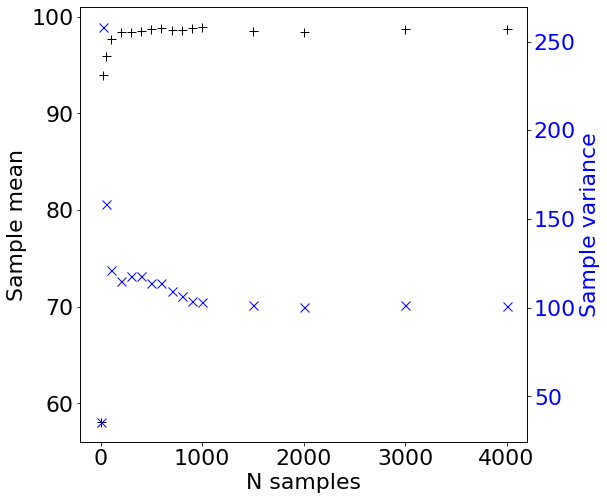

In [8]:

fig, ax = plt.subplots(figsize=figsize)

c1='k'
c2='b'
s1='+'
s2='x'

markersize = 9.0

ax.plot(n, m, f'{c1}{s1}', 
        label='sample mean',
        ms=markersize)
ax.set_xlabel('N samples')
ax.set_ylabel('Sample mean', color=c1)
ax.tick_params(axis='y', labelcolor=c1)
ax2 = ax.twinx()
ax2.plot(n, v, f'{c2}{s2}', 
         label='sample variance',
         ms=markersize)
ax2.set_ylabel('Sample variance', color=c2)
ax2.tick_params(axis='y', labelcolor=c2)



In [59]:
help(ax.plot)

Help on method plot in module matplotlib.axes._axes:

plot(*args, scalex=True, scaley=True, data=None, **kwargs) method of matplotlib.axes._subplots.AxesSubplot instance
    Plot y versus x as lines and/or markers.
    
    Call signatures::
    
        plot([x], y, [fmt], *, data=None, **kwargs)
        plot([x], y, [fmt], [x2], y2, [fmt2], ..., **kwargs)
    
    The coordinates of the points or line nodes are given by *x*, *y*.
    
    The optional parameter *fmt* is a convenient way for defining basic
    formatting like color, marker and linestyle. It's a shortcut string
    notation described in the *Notes* section below.
    
    >>> plot(x, y)        # plot x and y using default line style and color
    >>> plot(x, y, 'bo')  # plot x and y using blue circle markers
    >>> plot(y)           # plot y using x as index array 0..N-1
    >>> plot(y, 'r+')     # ditto, but with red plusses
    
    You can use `.Line2D` properties as keyword arguments for more
    control on the ap

In [ ]:
key = jax.random.PRNGKey(55)
x = 1000
samples = sample(key, 100, ss, x)

samples = np.array(samples)
plt.hist(samples, bins=20)
plt.show()

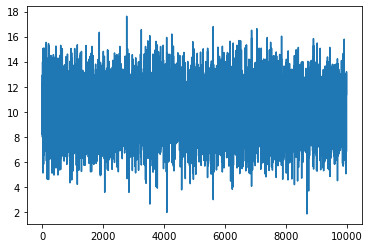

In [13]:
plt.plot(np.arange(0, len(samples), 1), samples)

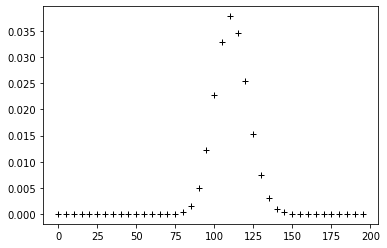

In [22]:
x = np.arange(0, 200, 5)
y = pstar(x)
x = np.array(x)
y = np.array(y)
plt.plot(x, y, 'k+')

In [18]:
y

DeviceArray([0.0000000e+00, 4.8616059e-35, 2.0589512e-26, 5.3621473e-20,
             4.9497573e-15, 3.7704138e-11, 3.9129809e-08, 7.7182194e-06,
             3.6680687e-04, 5.0170063e-03, 2.2677615e-02, 3.7836723e-02,
             2.5507245e-02, 7.4922182e-03, 1.0218829e-03, 6.8374189e-05,
             2.3526670e-06, 4.3396767e-08, 4.4513040e-10, 2.6228802e-12,
             9.1411626e-15, 1.9343177e-17, 2.5450446e-20, 2.1273291e-23,
             1.1520056e-26, 4.1163017e-30, 9.8637825e-34, 1.6104799e-37,
             0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
             0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
             0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
             0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
             0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
             0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
             0.0000000e+00, 0.0000000e+00, 0.000000

In [ ]:
key = jax.random.PRNGKey(13)
for i in range(40):
    key, subkey = jax.random.split(key)
    ss(key=subkey)
    

In [76]:
def body(val):
    key, r, count = val
    count += 1
    key, subkey = jax.random.split(key)
    r = jax.random.uniform(subkey)
    return key, r, count

def cond_func(val):
    key, r, count = val
    return r < 0.5

count = 0

r = 0.3
key = jax.random.PRNGKey(13)

val = key, r, count
val = jax.lax.while_loop(cond_func, body, val)

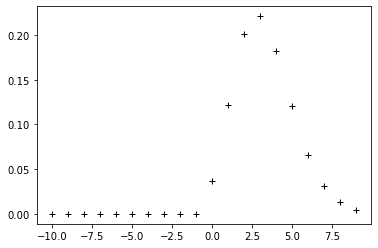

In [44]:
x = np.arange(-10, 10)
y = jsp.stats.poisson.pmf(x, 3.3)
plt.plot(x, y, 'k+')

In [86]:
def f(val):
    val = jax.lax.cond(
        val[0] > val[1], 
        lambda val: val[0],
        lambda val: val[1], 
        val)
    return val

jf = jax.jit(f)
jf((1, 2))

DeviceArray(2, dtype=int32, weak_type=True)

In [10]:
import scipy as sp

In [26]:
sp.stats.poisson.interval(.999, 1)

(0.0, 6.0)

In [37]:
f = partial(sp.stats.poisson.interval, alpha=0.999)

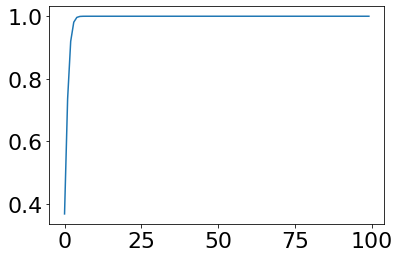

In [56]:
x = np.arange(0, 100, 1)
y = jsp.stats.poisson.cdf(x, mu=1)
plt.plot(x, np.array(y))

In [145]:
def find_min_poisson_bounds__s(mu, cpm=0.999, tolerance=1e-4, step_scale = 0.001):
    """Algorith to compute the bounds of the poisson distribution that encompass
       cpm cumulative probability mass. Note the bounds may not be symmetric about the median
    
       Params:
              
         mu:  the rate of the poisson distribution
         
         cpm: float, 0 < cpm < 1
           The cumulative probability mass (cpm) under the curve
           
         
       return:
         (L, R): (int, int) the left and right bounds for the distribution    
    """
    
    cdf = jsp.stats.poisson.cdf
    step_size = mu * step_scale

    found_lb = False
    found_rb = False
    
    # Begin at 50
    
    lb, rb = jax.lax.cond(
        mu < 50,
        lambda mu: (0.5*mu, 1.5*mu),
        lambda mu: (0., 150.),
        mu)
    
    l_prob_mass = cdf(lb, mu=mu)
    
    found_lb = jax.lax.cond(
        l_prob_mass > tolerance,
        lambda : True,
        lambda : False)
    
    r_prob_mass = cdf(rb, mu=mu)
    
    found_rb = jax.lax.cond(
        r_prob_mass < tolerance,
        lambda : True,
        lambda : False)
    
    
    
    def lcond(val):
        lb, flb, tol, step_size = val
        l_prob_mass = cdf(lb, mu=mu)
        flb = jax.lax.cond(
            l_prob_mass > tol,
            lambda : True,
            lambda : False)
        
        return flb == False
    
    def lbody(val):
        lb, flb, tol, step_size = val
        val = lb + step_size, flb, tol, step_size
        
        return val
    
    def rcond(val):
        rb, frb, tol, step_size = val
        r_prob_mass = cdf(rb, mu=mu)
        frb = jax.lax.cond(
            r_prob_mass > tol,
            lambda : True,
            lambda : False)
        
        return frb == False
    
    def rbody(val):
        rb, frb, tol, step_size = val
        val = rb - step_size, frb, tol, step_size
        return val
        
    lbval = lb, found_lb, tolerance, step_size
    lb, found_lb, tolerance, step_size = jax.lax.while_loop(
        lcond,
        lbody,
        lbval)
    
    rbval = rb, found_rb, tolerance, step_size
    rb, found_rb, tolerance, step_size = jax.lax.while_loop(
        rcond,
        rbody,
        rbval)
    
    return lb, rb  
    

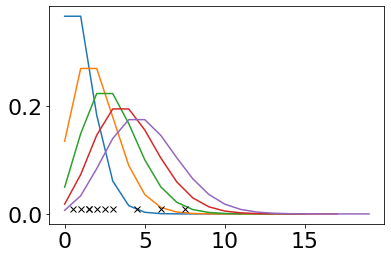

In [146]:
mus = [1, 2, 3, 4, 5]
bounds = []
for mu in mus:
    find_bounds = partial(find_min_poisson_bounds__s, mu=mu)
    bounds.append(find_bounds())
    
def plot_poisson_and_bounds(mu, lb=0.5*mu, rb=1.5*mu, h=0.01, c='kx' ):
    x = np.arange(0, 2*mu + 10)
    y = sp.stats.poisson.pmf(x, mu=mu)
    plt.plot(x, y)
    plt.plot(lb, h, c)
    plt.plot(rb, h, c)

for i, mu in enumerate(mus):
    lb, rb = bounds[i]
    
    plot_poisson_and_bounds(mu=mu, lb=lb, rb=rb)

In [140]:
jsp.stats.poisson.cdf

[(DeviceArray(0., dtype=float32, weak_type=True),
  DeviceArray(-0.00094347, dtype=float32, weak_type=True)),
 (DeviceArray(0., dtype=float32, weak_type=True),
  DeviceArray(-0.00081787, dtype=float32, weak_type=True)),
 (DeviceArray(0., dtype=float32, weak_type=True),
  DeviceArray(-0.00181699, dtype=float32, weak_type=True)),
 (DeviceArray(0., dtype=float32, weak_type=True),
  DeviceArray(-7.8870915e-05, dtype=float32, weak_type=True)),
 (DeviceArray(0., dtype=float32, weak_type=True),
  DeviceArray(-0.00075248, dtype=float32, weak_type=True))]

In [121]:
a, b, c = jax.lax.while_loop(lambda *(d, e, f): e == False,
                            lambda *(d, e, f): (2, True, f),
                            (1, False, True))

SyntaxError: invalid syntax (1637388943.py, line 1)

In [92]:
jax.lax.cond(mu < 50, lambda mu: 0., lambda mu: 0.5*mu, mu)

DeviceArray(25., dtype=float32, weak_type=True)

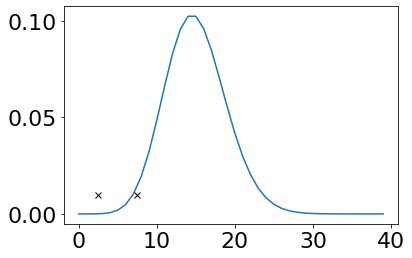

In [148]:
plot_poisson_and_bounds(15)


# (0, 15) -> 0, bound(0)

# [15, 50) 

In [151]:
1- jsp.stats.poisson.cdf(30, 15)

DeviceArray(0.00019729, dtype=float32)

In [ ]:
def find_left_bound__s(start, step_size, percentile : float, cdf):
    
    lb = start
    t = percentile
    ss = step_size
    
    def cond(val):
        lb, ss, t = val
        return t > cdf(lb)
    
    def body(val):
        lb, ss, t
        return lb + ss, ss, t
    
    
    lb, ss, t = jax.lax.while_loop(
        cond, body, (lb, step_size, t)
    )
    
    return lb

mu = 99
cdf = partial(jsp.stats.poisson.cdf, mu=mu)
find_left_bound = partial(find_left_bound__s, cdf=cdf)
find_left_bound(0, 0.1, 0.001)